In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

В данном ноутбуке рассмотрен алгоритм переноса стиля с одной картинки на другую с использованием предобученной модели VGG19. Перенос производится посредством градиентного спуска, осуществляемого на самом изображении, без предварительного обучения модели.
За основу алгоритма преобразования был взять механизм из тьюториала https://pytorch.org/tutorials/advanced/neural_style_tutorial.html.
Для того, чтобы алгоритм можно было использовать в работе Telegram бота, из модели VGG19 были предварительно удалены неиспользуемые слои. Получившаяся "сокращенная" модель выгружена и используется для работы бота. В процессе обучения она передается в специально созданный класс Style_transfer, в рамках которого и выполняется преобразование изображения.


In [2]:
import torch
from torch.autograd import Variable
from collections import namedtuple
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
import os
import sys
import random
from PIL import Image
import glob
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import datasets
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import cv2
from IPython.display import clear_output
from torchvision.models import vgg19, VGG19_Weights
import gc
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42) #for reproducibility
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
        
    def forward(self, x):
        self.loss = F.mse_loss(x, self.target)
        return x
    
class StyleLoss(nn.Module):
    def __init__(self, target_features):
        super(StyleLoss, self).__init__()
        self.target = self.gram_matrix(target_features).detach()
    
    def gram_matrix(self, x):
        (b, c, h, w) = x.size()
        features = x.view(b*c, h*w)
        G = torch.mm(features, features.t())
        return G.div(b*c*h*w)
    
    def forward(self, x):
        G = self.gram_matrix(x)
        self.loss = F.mse_loss(G, self.target)
        return x

In [4]:
model = vgg19(weights = VGG19_Weights.DEFAULT).features.eval()

mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1,1,1)
        self.std = torch.tensor(std).view(-1,1,1)
        
    def forward(self, img):
        return (img - self.mean) / self.std

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 279MB/s]  


In [5]:
#определяем слои модели, которые будут использоваться для content loss и style loss
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

In [8]:
def get_style_model(model, norm_mean, norm_std, content_layers = content_layers_default,
                              style_layers = style_layers_default):
    normalization = Normalization(norm_mean, norm_std)
    
    content_losses = []
    style_losses = []
    
    style_model = nn.Sequential(normalization)
    
    i = 0
    for layer in model.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
            #layer = nn.AvgPool2d(kernel_size=2)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
        
        style_model.add_module(name, layer)
                         
        if i == 5:
            break

    return style_model 

In [9]:
img_model = get_style_model(model, mean, std)

/tmp/ipykernel_42/1393927329.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1,1,1)
/tmp/ipykernel_42/1393927329.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1,1,1)


In [10]:
style_transform = transforms.Compose(
    [transforms.Resize((256, 256)),
     transforms.ToTensor()])

cont_image = Image.open('/kaggle/input/images/Albrecht_Durer_100.jpg')
style_image = Image.open('/kaggle/input/images/Vasiliy_Kandinskiy_11.jpg')

cont_image = style_transform(cont_image).reshape(1,3,256,256)
style_image = style_transform(style_image).reshape(1,3,256,256)

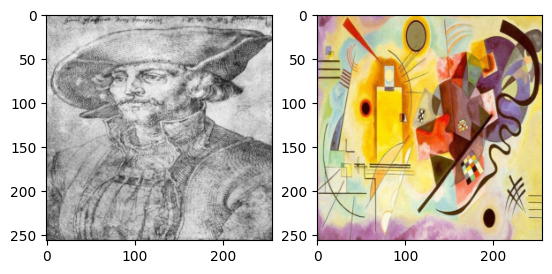

In [11]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(cont_image.reshape(3,256,256).permute(2, 1, 0).permute(1, 0, 2))
plt.subplot(1,2,2)
plt.imshow(style_image.reshape(3,256,256).permute(2, 1, 0).permute(1, 0, 2))

In [12]:
#выгружаем модель с нужными слоями VGG19
model_scripted = torch.jit.script(img_model)
model_scripted.save('model_scripted.pt')

In [17]:
class Style_transfer(nn.Module):
    def __init__(self, model):
        super(Style_transfer, self).__init__()
        self.base_model = model
        
    def make_model(self, content_img, style_img):
        content_layers = ['conv_4']
        style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
        content_losses = []
        style_losses = []
        style_model = nn.Sequential()

        for layer in self.base_model.named_children():
            style_model.add_module(layer[0], layer[1])
            if layer[0] in content_layers:
                target = style_model(content_img).detach()
                content_loss = ContentLoss(target)
                style_model.add_module('content_loss_{}'.format(layer[0][-1]), content_loss)
                content_losses.append(content_loss)
            if layer[0] in style_layers:
                target_feature = style_model(style_img).detach()
                style_loss = StyleLoss(target_feature)
                style_model.add_module('style_loss_{}'.format(layer[0][-1]), style_loss)
                style_losses.append(style_loss)
        return style_model, content_losses, style_losses
    
    def get_input_optimizer(self, input_img):
        optimizer = optim.LBFGS([input_img])
        return optimizer
    
    def transform(self, content_img, style_img, num_steps=300, style_weight=100000, content_weight=1):
        style_model, content_losses, style_losses = self.make_model(content_img, style_img)
        
        input_img = content_img.clone()
                
        input_img.requires_grad_(True)
        style_model.eval()
        style_model.requires_grad_(False)
        optimizer = self.get_input_optimizer(input_img)
        
        run = [0]
        while run[0] <= num_steps:
            def closure():
                with torch.no_grad():
                    input_img.clamp_(0,1)
                optimizer.zero_grad()
                style_model(input_img)
                style_score = 0
                content_score = 0
            
                for sl in style_losses:
                    style_score += sl.loss
                for cl in content_losses:
                    content_score += cl.loss
                
                style_score *= style_weight
                content_score *= content_weight
            
                loss = style_score + content_score
                loss.backward()
            
                run[0] += 1
                if run[0] % 50 == 0:
                    print('run {}'.format(run))
                    print('Style Loss: {:4f} Content Loss: {:4f}'.format(style_score.item(), content_score.item()))
                    print()
                return style_score + content_score
        
            optimizer.step(closure)
        
        with torch.no_grad():
            input_img.clamp_(0,1)
        
        return input_img    
        

In [18]:
style_model = Style_transfer(img_model)
input_img = style_model.transform(cont_image, style_image)

run [50]
Style Loss: 66.241844 Content Loss: 31.920286

run [100]
Style Loss: 19.616360 Content Loss: 28.285830

run [150]
Style Loss: 9.209022 Content Loss: 25.041286

run [200]
Style Loss: 5.380672 Content Loss: 22.875265

run [250]
Style Loss: 3.411492 Content Loss: 21.384724

run [300]
Style Loss: 2.547103 Content Loss: 20.478533



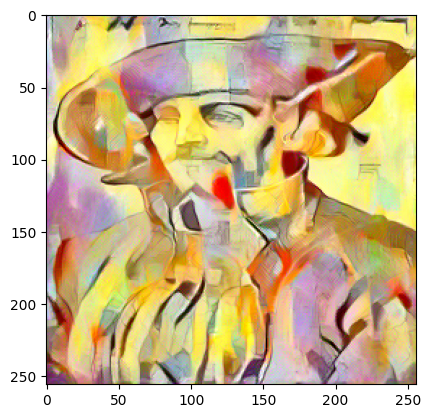

In [19]:
plt.figure()
plt.imshow(input_img.detach().numpy().reshape(3,256,256).swapaxes(0,2).swapaxes(0, 1))